In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pywt
from scipy.integrate import odeint

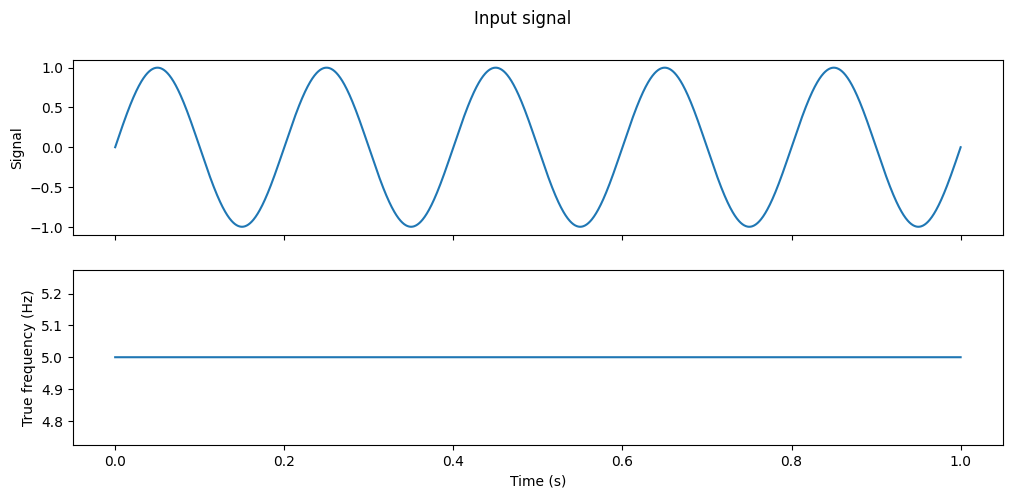

In [289]:
def gaussian(x, x0, sigma):
    return np.exp(-np.power((x - x0) / sigma, 2.0) / 2.0)


def make_chirp(t, t0, a):
    frequency = (a * (t + t0))**2
    chirp = np.sin(2 * np.pi * frequency * t)
    return chirp, frequency


# generate signal
time = np.linspace(0, 1, 2000)
signal = (np.sin(2*np.pi*time * 5))
frequency = np.ones_like(signal)*5
# plot signal
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12,5))
axs[0].plot(time, signal)
axs[0].set_ylabel("Signal")
axs[1].plot(time, frequency, label="frequency1")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("True frequency (Hz)")
plt.suptitle("Input signal")
plt.show()

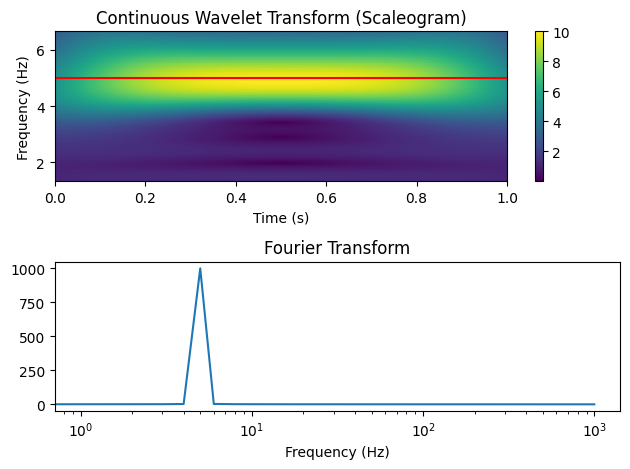

In [290]:
# perform CWT
wavelet = "cmor1.5-1.0"

# logarithmic scale for scales, as suggested by Torrence & Compo:
widths          = np.geomspace(300, 1500, num=300)
sampling_period = np.diff(time).mean()
cwtmatr, freqs  = pywt.cwt(signal, widths, wavelet, sampling_period=sampling_period)
# absolute take absolute value of complex result
cwtmatr = np.abs(cwtmatr[:-1, :-1])

# plot result using matplotlib's pcolormesh (image with annoted axes)
fig, axs = plt.subplots(2, 1)
pcm = axs[0].pcolormesh(time, freqs, cwtmatr)
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Frequency (Hz)")
axs[0].set_title("Continuous Wavelet Transform (Scaleogram)")
axs[0].plot(time, frequency, color="red")
fig.colorbar(pcm, ax=axs[0])

# plot fourier transform for comparison
from numpy.fft import rfft, rfftfreq

yf = rfft(signal)
xf = rfftfreq(len(signal), sampling_period)
plt.semilogx(xf, np.abs(yf))
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_title("Fourier Transform")
plt.tight_layout()

In [17]:
def mean_frequency(freqs, coeff):
    n = coeff.shape[1]
    mean_freqs = []
    for i in range(n):
        total_weight = np.sum(coeff[:,i])
        average_freq = np.sum(freqs[:-1]*coeff[:,i])/total_weight
        mean_freqs.append(average_freq)
    return np.array(mean_freqs)

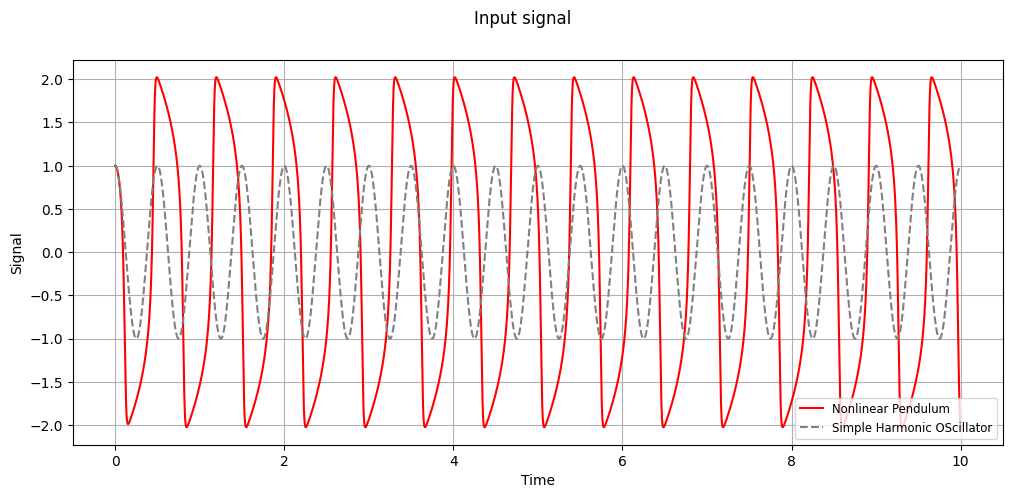

In [14]:
ti, tf, dt = 0, 10, 1e-3

t  = np.arange(ti, tf, dt)
w0 = 2*np.pi*2
mu = 3
X0 = [1, 0]

def ODE(X, t): return [X[1], -w0**2 * X[0] + mu*w0*(1 - X[0]**2)*X[1]]
def SHO_ODE(X, t): return [X[1], -w0**2 * X[0]]

pendulum    = odeint(ODE, X0, t)[:,0]
SHO         = odeint(SHO_ODE, X0, t)[:,0]

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(t, pendulum, label="Nonlinear Pendulum", color="red")
ax.plot(t, SHO, label="Simple Harmonic OScillator", linestyle="--", color="gray")
ax.set_ylabel("Signal")
ax.set_xlabel("Time")
ax.grid()
ax.legend(fontsize='small')
plt.suptitle("Input signal")
plt.savefig("solution_comparison.png")
plt.show()

In [16]:
wavelet = "cmor0.5-4.0"

sampling_period = dt
frequencies = np.arange(0.5, 20, 1e-2)*sampling_period
scale = pywt.frequency2scale(wavelet, frequencies)

cwtmatr, freqs  = pywt.cwt(pendulum, scale, wavelet, sampling_period=sampling_period)
cwtmatr         = np.abs(cwtmatr[:-1, :-1])

sho_cwtmatr, sho_freqs  = pywt.cwt(SHO, scale, wavelet, sampling_period=sampling_period)
sho_cwtmatr             = np.abs(sho_cwtmatr[:-1, :-1])


SHO_frequency   = np.ones_like(pendulum)*w0/(2*np.pi)

from numpy.fft import rfft, rfftfreq

pendulum_fft = rfft(pendulum)
SHO_fft      = rfft(SHO)
frequencies  = rfftfreq(len(pendulum), sampling_period)

In [18]:
Mean_Pendulum_freq = mean_frequency(freqs, cwtmatr)
Mean_SHO_freq = mean_frequency(sho_freqs, sho_cwtmatr)

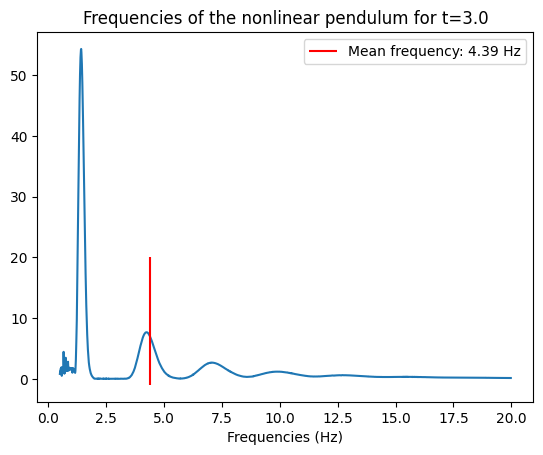

In [19]:
i = 3_000
mf = Mean_Pendulum_freq[i]
plt.title(f"Frequencies of the nonlinear pendulum for t={t[i]}")
plt.plot(freqs[:-1], cwtmatr[:,i])
plt.vlines(mf, -1, 20, color="red", label=f"Mean frequency: {mf:.2f} Hz")
plt.xlabel("Frequencies (Hz)")
plt.legend()
plt.show()

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(13,10))

pcm = axs[0,0].pcolormesh(t, freqs, cwtmatr)
axs[0,0].set_xlabel("Time (s)")
axs[0,0].set_ylabel("Frequency (Hz)")
axs[0,0].set_title("Continuous Wavelet Transform for VdP")

axs[0,0].plot(t[:-1], Mean_Pendulum_freq, color="red", linestyle='--', lw=1.5, alpha=1,label="Mean Frequency")
axs[0,0].plot(t, SHO_frequency, color="red", lw=0.5, alpha=0.7,label="Correct SHO Frequency")
fig.colorbar(pcm, ax=axs[0,0])
axs[0,0].legend()

pcm2 = axs[0,1].pcolormesh(t, sho_freqs, sho_cwtmatr)
axs[0,1].set_xlabel("Time (s)")
axs[0,1].set_ylabel("Frequency (Hz)")
axs[0,1].set_title("Continuous Wavelet Transform for SHO")
axs[0,1].plot(t[:-1], Mean_SHO_freq, color="red", linestyle='--', lw=1.5, alpha=1, label="Mean SHO frequency")
axs[0,1].plot(t, SHO_frequency, color="red", linestyle='-', lw=0.5, alpha=0.7, label="Correct SHO Frequency")
fig.colorbar(pcm2, ax=axs[0,1])
axs[0,1].legend()

pcm3 = axs[1,0].pcolormesh(t, sho_freqs, np.abs(sho_cwtmatr-cwtmatr))
axs[1,0].set_xlabel("Time (s)")
axs[1,0].set_ylabel("Frequency (Hz)")
axs[1,0].set_title("Absolute difference between the CWTs")
fig.colorbar(pcm3, ax=axs[1,0])

axs[1,1].plot(frequencies, np.abs(pendulum_fft), color="red", label="VdP FFT")
axs[1,1].plot(frequencies, np.abs(SHO_fft), color="gray", label="SHO FFT")
axs[1,1].set_xlabel("Frequency (Hz)")
axs[1,1].set_title("Fourier Transform")
axs[1,1].set_xscale("log")
axs[1,1].legend()

plt.savefig("Comparison_cwt.png", dpi=300)